# Ideas for future

---

# Introduction to my Idea

### **If we see this lunar dataset , we can see that the the colour/texture difference between the lunar surface and lunar rocks is very small . And if we take a close look at our project of detecting bedding layer on the surface of a hill/rock we will see that the colour/texture difference between the bedding layer and the hill/rock is pretty similar to the difference of the lunar surface and the lunar rocks. So using tis dataset to train the NN so that we can detect the bedding layer.**

In this Project we going to use U-net Neural network architecture which is the best NN structure for the purpose of Image segmentation. This NN will be fed with Artificial Lunar Landsacpe dataset.

> This is a Deep learning - computer vision project, where use of techniques like Transefer Learning, Callbacks, U-net model building and optimization, Techinical Documentation and plotting are used.





## Our goal is to increase the val_iou_score as much as we can for this project using any method. The evaluation of our model will be based on acquired val_iou_score.

### Some pointers to increase the performance

* Increase the number of epochs
* Increase the number of layers in your model
* Using SOTA high performance networks with transfer learning
* Using callbacks and carefully observing your model performance


In [ ]:
!pip install segmentation_models

In [ ]:
# import the necessary Library

import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf    
import keras
from keras.callbacks import EarlyStopping
from keras.models import Model,load_model
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [ ]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [ ]:
H = 480 # height of image # Height and widht of the image has been changed to 480 in the place of 256 that was originally given. when the original size of image 720 * 480 is rescalled to some lower value there is a some data loss. Therefore, smaller the value bigger will be the data losss, so i have increased the value of dimensions to 480*480 instead of 256*256 that was originally given to us with this assignment notebook.
W = 480 # width of image  #reason for heights and weights increase is given in above line.

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(480 x 480). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [ ]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [ ]:
batch_size = 16 #batch size of 8 was given by default, I have increased it to 16 due to some results of reseasrch papers showing increase in batcch size increases the performance of the model. Also, if we increase batch size to some the maximum number that is 1 image per batch then there will be the case of over-fitting. reason for explaining this is that, there is a sweet spot of batch size that should be looked for by experimentations and will always be specific to that dataset only. there is no single batch size number which is best for every dataset.

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture

Here we are going to use transfer learning to build U-net architecture using Vgg-16 backbone.

><u>Transfer Leranring</u>: Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

In [ ]:

#### Step 1: Creating a base model 
IMG_SHAPE = (480, 480, 3)

# include_top specify that we don't want to use the top layer (classifier)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Step 2: Freezing the base

# It is important to freeze the convolutional base before you compile and train the model.
# Freezing prevents the weights in a given layer from being updated during training
# VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

#### Step 3: Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# head layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

# Let's take a look at the final model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0     

In [ ]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone
# and pretrained imagenet weights

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path
model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Load model and compile

In upcoming cells you will see you of many callbacks like ModelCheckpoint, ReducedLROnPlateau, and earlyStopping. These callbacks are used for the purpose of training our model efficiently. Callbacks control parameters like learning rate or stopping the training process altogether if performance of the model does not increase and beauty of callbacks they control the model during the training run automatically as per the arguments provided by us.

>For our model, I have used IOU score for guaging the performance. IOU score is between 0 and 1, Higher the score better is the performance. For these perpuose we will monitor Val_iou score to see if our model is estimating as per our expectation.

In [ ]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #importing the necessary modules for callbacks
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3) #input shapes, default one with notebook (256,256,3) to presently this (480,480,3). This is done to accomadate the height and width increase in the input image that we have changed in the previous cells above. 
num_classes = 4
lr = 1e-5 #decreased learning rate gives better generalization
batch_size = 16 #increasing the batch size can provide better performance
epochs = 30 #Increased epochs give better scores

""" Model building and compiling """
# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8, decay=1e-6), #epsilon and decay are added as a way to increase the performance. epsilon is a very small number to prevent any division by zero in the implementation. decay helps us to increase performance by reducing the momentum of the optimizer. Adam uses Momentum and Adaptive Learning Rates to converge faster.
               metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


""" Callbacks """
#A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). You can use callbacks to: Write TensorBoard logs after every batch of training to monitor your metrics, Periodically save your model to disk, Do early stopping, Get a view on internal states and statistics of a model during training.

current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True), # Create a callback that saves the model periodically as training moves along the number of epochs.
             
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6), #This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
                         
             
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),  #Stop training when a monitored metric has stopped improving.
]

## Train model

In [ ]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
        )

Epoch 1/30
488/488 [==============================] - 449s 878ms/step - loss: 0.8527 - iou_score: 0.0419 - f1-score: 0.0687 - val_loss: 0.6794 - val_iou_score: 0.0809 - val_f1-score: 0.1219

Epoch 00001: val_iou_score improved from -inf to 0.08091, saving model to models/LunarModel.h5
Epoch 2/30
488/488 [==============================] - 394s 801ms/step - loss: 0.5420 - iou_score: 0.1470 - f1-score: 0.1832 - val_loss: 0.4123 - val_iou_score: 0.2017 - val_f1-score: 0.2231

Epoch 00002: val_iou_score improved from 0.08091 to 0.20167, saving model to models/LunarModel.h5
Epoch 3/30
488/488 [==============================] - 390s 799ms/step - loss: 0.3901 - iou_score: 0.2073 - f1-score: 0.2265 - val_loss: 0.3376 - val_iou_score: 0.2178 - val_f1-score: 0.2327

Epoch 00003: val_iou_score improved from 0.20167 to 0.21783, saving model to models/LunarModel.h5
Epoch 4/30
488/488 [==============================] - 390s 800ms/step - loss: 0.2913 - iou_score: 0.2439 - f1-score: 0.2527 - val_loss: 

In [ ]:
print(model_history.history)

{'loss': [0.8527103662490845, 0.5420312285423279, 0.39006099104881287, 0.2912938594818115, 0.21958336234092712, 0.166056290268898, 0.1271500438451767, 0.09960305690765381, 0.0791393294930458, 0.06478264182806015, 0.060436200350522995, 0.05299348756670952, 0.04458143189549446, 0.03814468905329704, 0.036440689116716385, 0.03360618278384209, 0.029856979846954346, 0.025419961661100388, 0.023061664775013924], 'iou_score': [0.04189640283584595, 0.14700353145599365, 0.20734016597270966, 0.24391959607601166, 0.2769821286201477, 0.2821265161037445, 0.3102298080921173, 0.3795395791530609, 0.45430997014045715, 0.4971936047077179, 0.5417174100875854, 0.5360434651374817, 0.5909129977226257, 0.6454961895942688, 0.6212508678436279, 0.6027880907058716, 0.5820749402046204, 0.5590858459472656, 0.55048668384552], 'f1-score': [0.06873402744531631, 0.1832108348608017, 0.22645670175552368, 0.25269803404808044, 0.2825470268726349, 0.2867071330547333, 0.3143528997898102, 0.3835873603820801, 0.4581254422664642

## Using our model for segmentation of rocks and boulders in some of the unknown test cases of Lunar Surface images.

In [ ]:
from skimage.io import imread
from skimage.transform import resize

# function to predict result 
def predict_image(img_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

#     ## Read mask
#     mask = imread(mask_path, as_gray = True)
#     mask = mask[:480, :480]
    
    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    
    
#     # calculating IOU score
#     inter = np.logical_and(mask, pred_mask)
#     union = np.logical_or(mask, pred_mask)
    
#     iou = inter.sum() / union.sum()

    return img,pred_mask

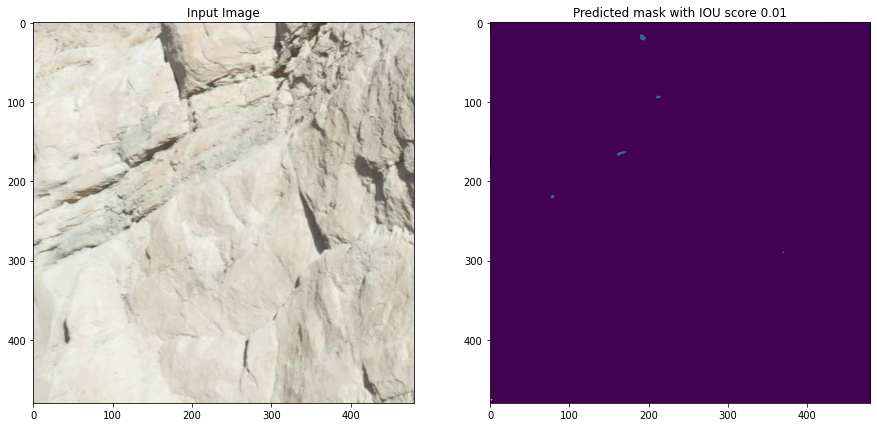

In [ ]:
img_path = '/kaggle/input/testmount2/_0566_frame2115.jpg'
# mask_path = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0042.png'

img,pred_mask= predict_image(img_path,model)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

# ax2.set_title("True Mask")
# ax2.imshow(mask)

ax2.set_title("Predicted mask with IOU score %.2f"%(iou))
ax2.imshow(pred_mask)

plt.show()

## As we can see some parts of the bedding layer are getting detected.